In [456]:
import pandas as pd
import numpy as np
import datetime
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler





Подошел к заданию следующим образом - нужно определить три аэропорта прилета с минимальной вероятностью задержки - то есть
в конкретную дату я знаю количество вылетов из аэропорта компанию перевозчика, номе рейса, дистанцию. Остальная информация в тестовой выборке
мне не известна

Загружаем данные

In [397]:
airports = pd.read_csv('airports.csv')
flights = pd.read_csv('flights.csv')

/var/folders/m9/x7jxk9jx2g9ch4ngnwz3n8wh0000gn/T/ipykernel_20130/1288301204.py:2: DtypeWarning:

Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.



Таблицы содержат следующую информацию

In [398]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [399]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

пропуски в данных


In [400]:
flights.isna().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype: int64

In [401]:
airports.isna().sum()

IATA_CODE    0
AIRPORT      0
CITY         0
STATE        0
COUNTRY      0
LATITUDE     3
LONGITUDE    3
dtype: int64

объединяю данные, удаляется информация о части аэропортовс кодом в виде цифр, дплее по координатам строю несколько графиков

In [402]:
flights = flights.merge(airports, how='right', left_on='ORIGIN_AIRPORT', right_on='IATA_CODE')

Добавляю колонку с датой

In [403]:
flights['DATE'] = pd.to_datetime(flights[['YEAR', 'MONTH', 'DAY']])

In [404]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,DATE
0,2015,1,1,4,EV,5103,N846AS,ABE,DTW,600,...,NaN,NaN,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.4404,2015-01-01
1,2015,1,1,4,EV,5579,N136EV,ABE,ATL,635,...,NaN,NaN,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.4404,2015-01-01
2,2015,1,1,4,EV,5267,N131EV,ABE,ATL,1600,...,NaN,NaN,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.4404,2015-01-01
3,2015,1,2,5,EV,5103,N849AS,ABE,DTW,600,...,NaN,NaN,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.4404,2015-01-02
4,2015,1,2,5,EV,6144,N15912,ABE,ORD,600,...,NaN,NaN,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.4404,2015-01-02


Проанализируем аэропорты по количеству вылетов

На карте

In [405]:
a = flights.groupby('ORIGIN_AIRPORT')['DATE'].count().sort_values(ascending=False).reset_index()
b = airports.merge(a, how='right', left_on='IATA_CODE', right_on='ORIGIN_AIRPORT')

In [406]:
fig = px.scatter_mapbox(b,
                        lon = b.LONGITUDE,
                        lat = b.LATITUDE,
                        zoom = 3,
                        color = b.DATE,
                        size = b.DATE,
                        width = 800,
                        height = 600,
)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

Теперь в разрезе дат
наблюдается цикличность, можно сделать вывод, что от дня недели зависит количество вылетов,
данные за октябрь отсутствую

<AxesSubplot:xlabel='DATE'>

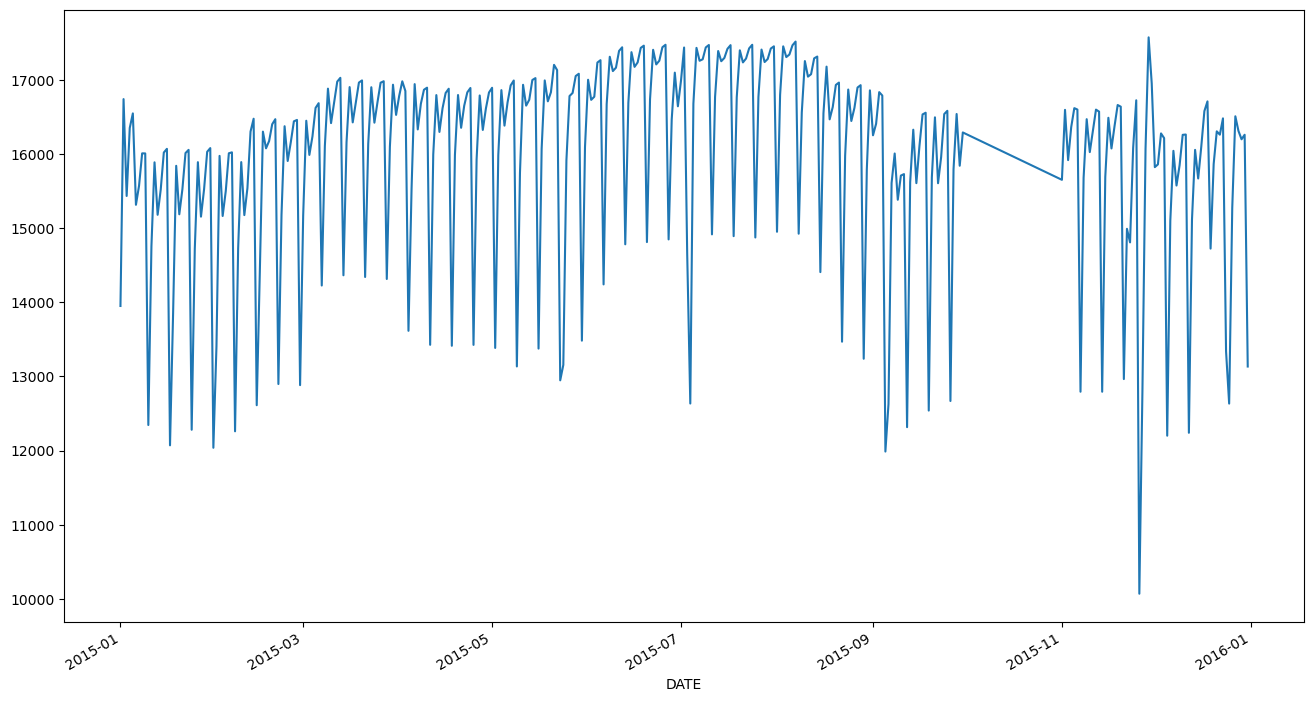

In [407]:
flights.groupby('DATE')['DATE'].count().plot(figsize=[16, 9])

Далее рассматриваю период январь - сентябрь

In [408]:
flights = flights.loc[flights['DATE'].between('2015-01-01', '2015-09-30')]

Тоже с заданными датами

<AxesSubplot:xlabel='DATE'>

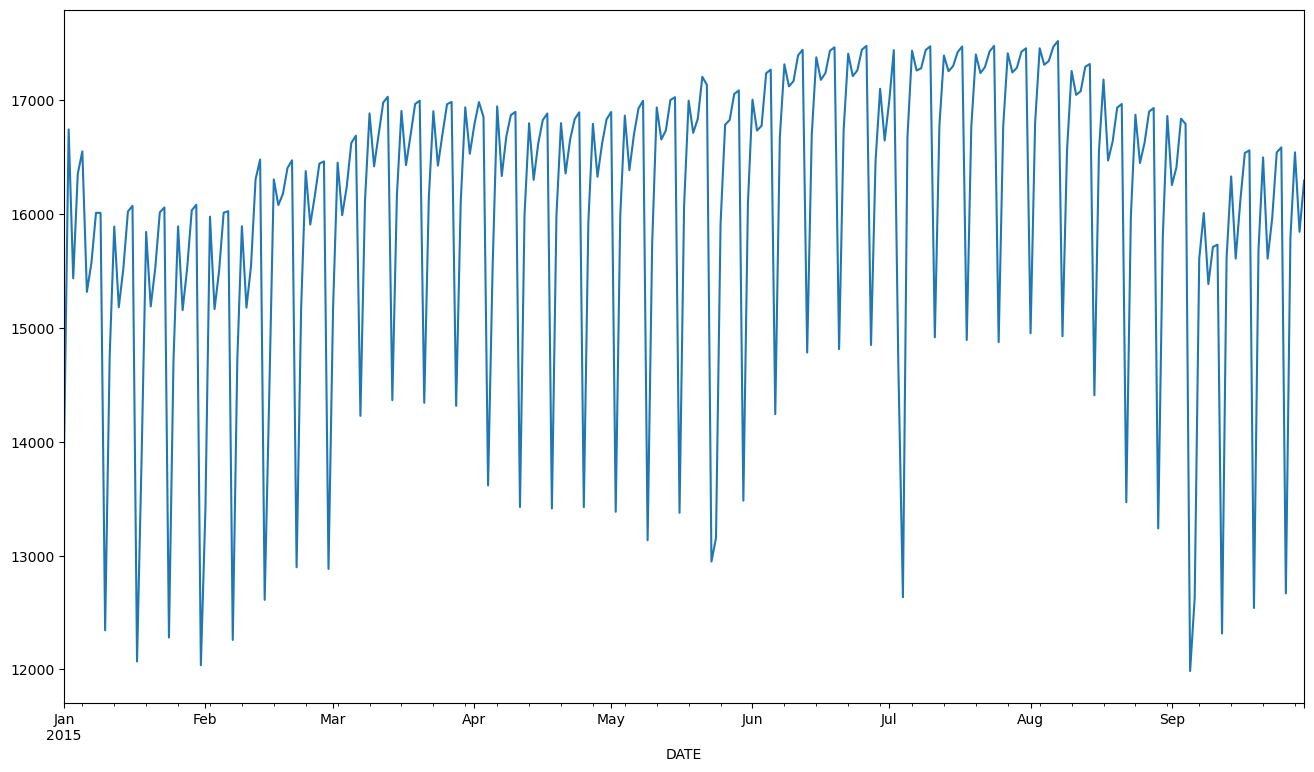

In [409]:
flights.groupby('DATE')['DATE'].count().plot(figsize=[16, 9])

Посмотрим на количество вылетов в разные дни недели - в выходные значительно снижается количество вылетов

<AxesSubplot:xlabel='DAY_OF_WEEK'>

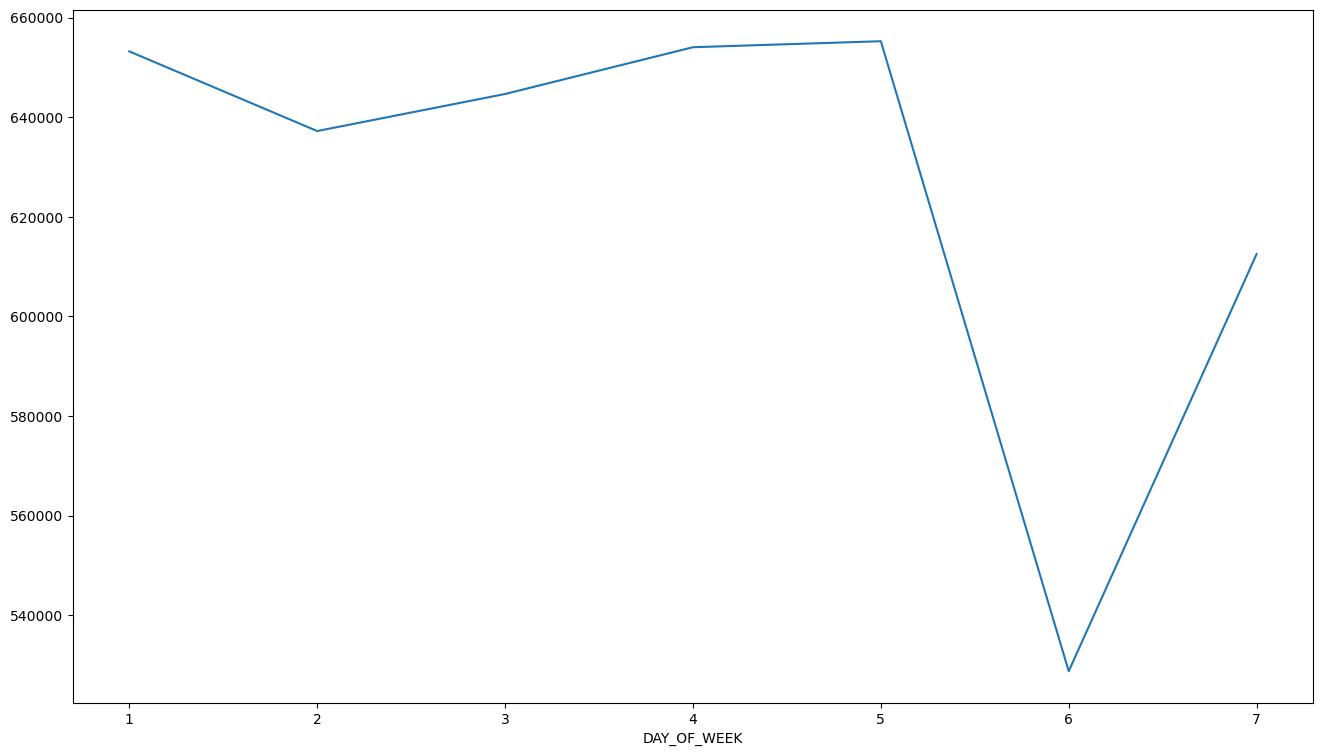

In [410]:
flights.groupby('DAY_OF_WEEK')['DATE'].count().plot(figsize=[16, 9])

Посмотрим на количество задержек
создадим колонку, которая будет отражать инфорацию о вылете самолета в срок. 1 - вылетел в срок, 0 - не вылетел в срок

In [411]:
flights['PROBABILITY'] = np.where(flights['DEPARTURE_DELAY']>0, 0, 1)

Посмотрим на распределение общева количества задержек по дням - прослеживается та же цикличность

<AxesSubplot:xlabel='DATE'>

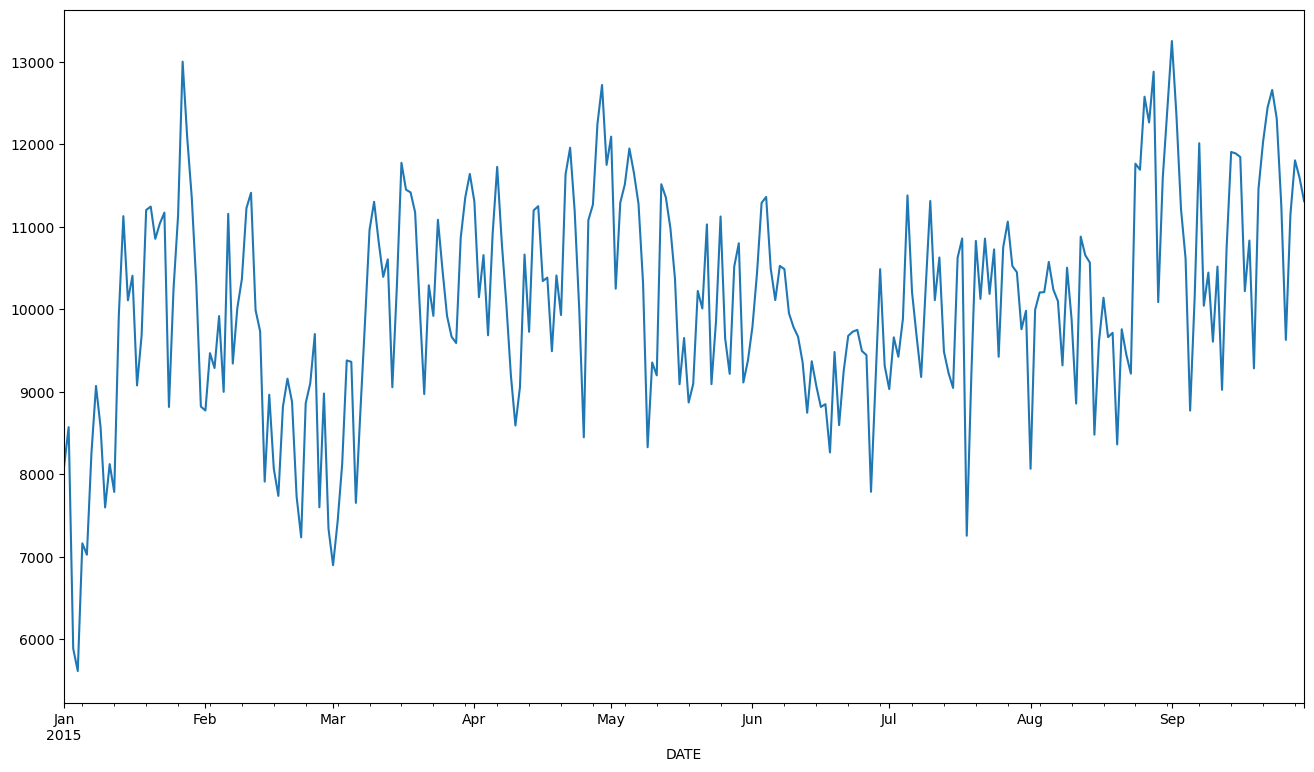

In [412]:
flights.query('PROBABILITY > 0').groupby('DATE')['PROBABILITY'].count().plot(figsize=[16, 9])

Тоже на карте для разных аэропортов

In [413]:
a = flights.query('PROBABILITY == 0').groupby('ORIGIN_AIRPORT')['PROBABILITY'].count().sort_values(ascending=False).reset_index()
b = airports.merge(a, how='right', left_on='IATA_CODE', right_on='ORIGIN_AIRPORT')

In [414]:
fig = px.scatter_mapbox(b,
                        lon = b.LONGITUDE,
                        lat = b.LATITUDE,
                        zoom = 3,
                        color = b.PROBABILITY,
                        size = b.PROBABILITY,
                        width = 800,
                        height = 600,
)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

Теперь посмотрим на среденее значение вероятности вылететь без задержки в разрезе дней

<AxesSubplot:xlabel='DAY_OF_WEEK'>

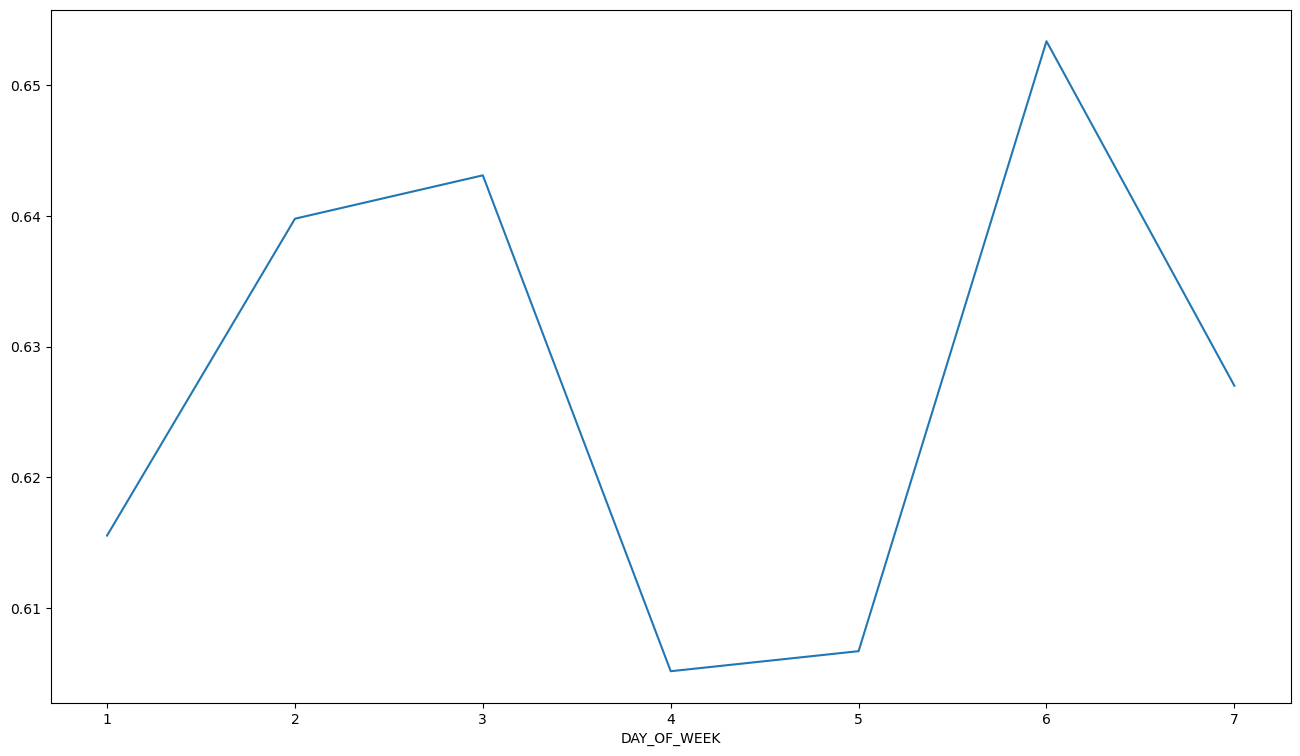

In [415]:
flights.groupby('DAY_OF_WEEK')['PROBABILITY'].mean().plot(figsize=[16, 9])

Совместим графики - прослеживается зависимость - чем больше количество вылетов, тем ниже вероятность улететь вовремя. Так же присутствуют пики по дням недели. И в целом, вначале пиков аэропорты справляюся, но при накоплении рейсов происходит резкое падение вылетов в срок.

<AxesSubplot:xlabel='DATE'>

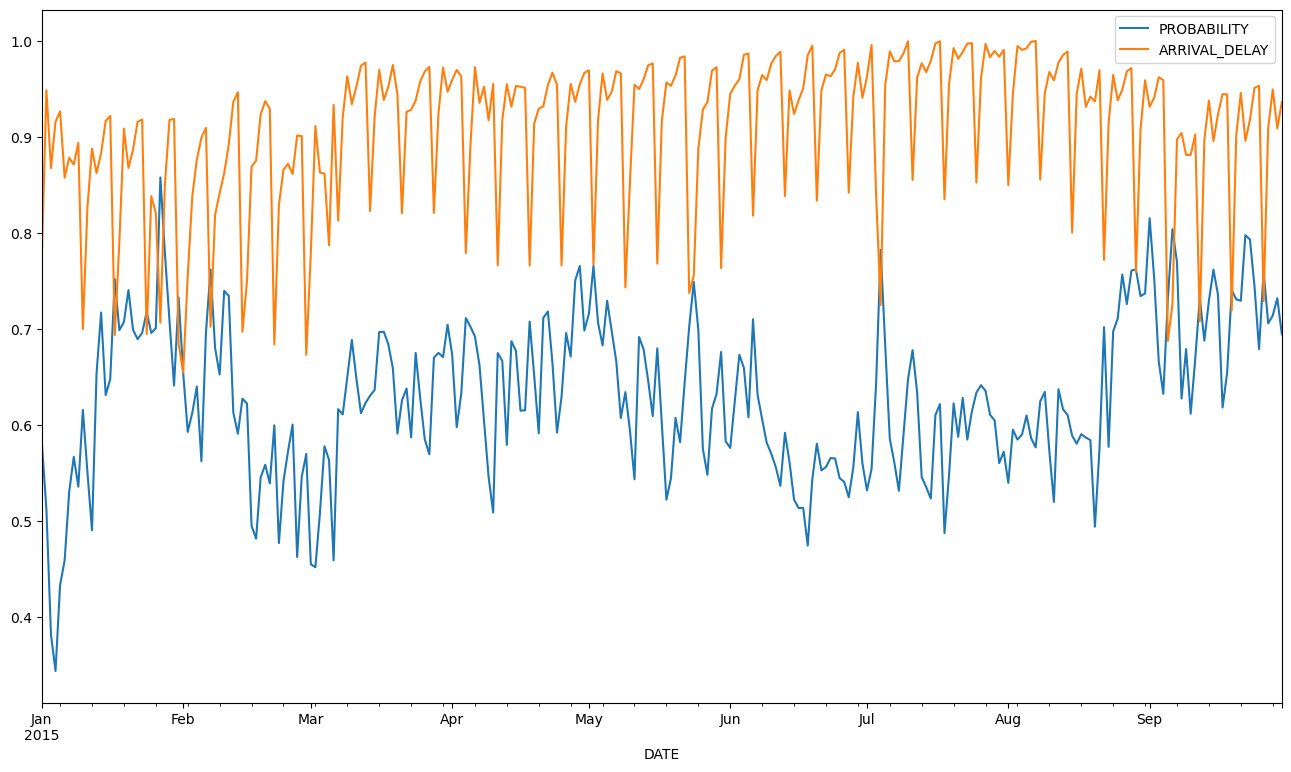

In [416]:
a = flights.groupby('DATE')['ARRIVAL_DELAY'].count().reset_index()
a['ARRIVAL_DELAY'] = a['ARRIVAL_DELAY']/a['ARRIVAL_DELAY'].max()
b = flights.groupby('DATE')['PROBABILITY'].mean().reset_index()
df = b.merge(a, how='right', left_on='DATE', right_on='DATE').set_index('DATE')
df.plot(figsize=[16, 9])

Тоже сделаем для дней недели

<AxesSubplot:xlabel='DAY_OF_WEEK'>

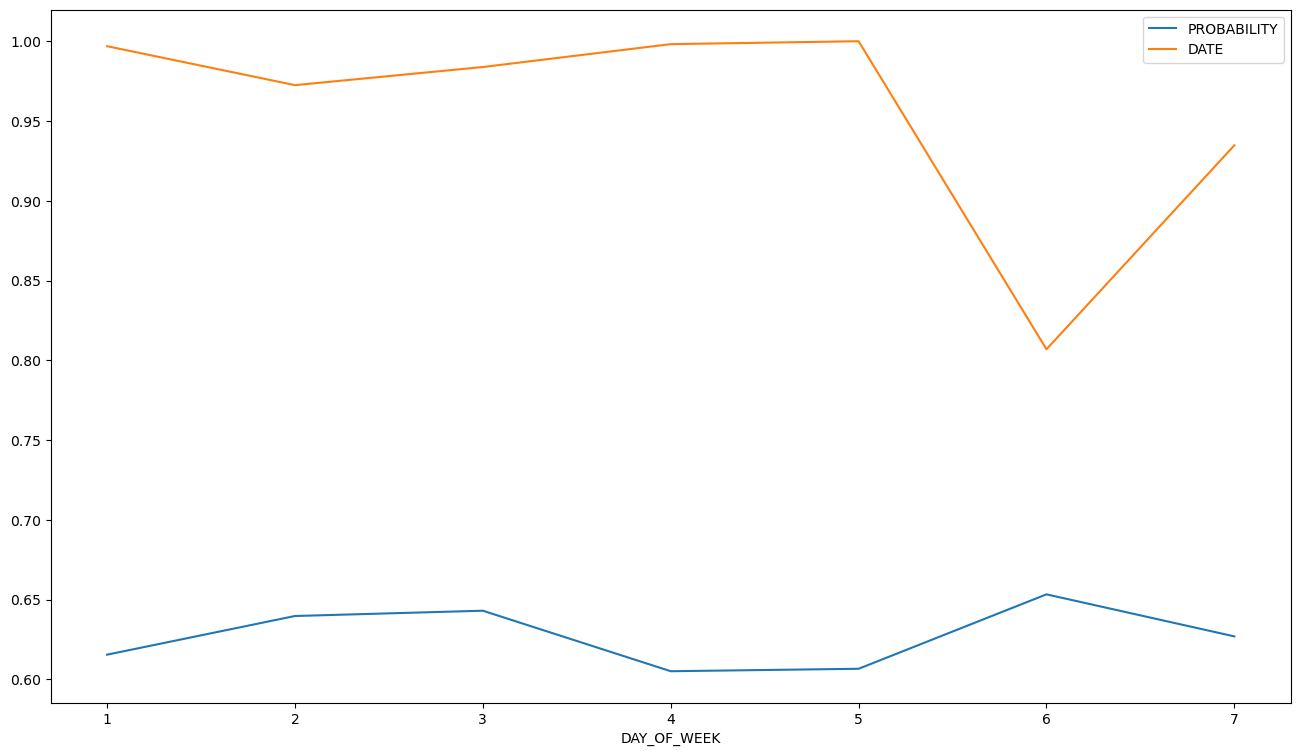

In [417]:
a = flights.groupby('DAY_OF_WEEK')['DATE'].count().reset_index()
a['DATE'] = a['DATE']/a['DATE'].max()
b = flights.groupby('DAY_OF_WEEK')['PROBABILITY'].mean().reset_index()
df = b.merge(a, how='right', left_on='DAY_OF_WEEK', right_on='DAY_OF_WEEK').set_index('DAY_OF_WEEK')
df.plot(figsize=[16, 9])

Теперь построим диаграмму, характеризующую вероятность улететь вовремя для авиаперевозчиков

<AxesSubplot:xlabel='AIRLINE'>

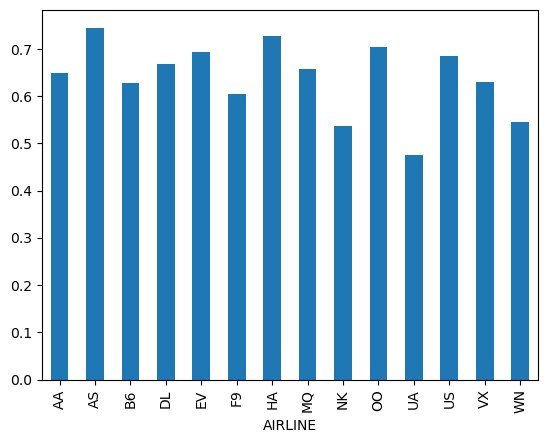

In [418]:
a = flights.groupby('AIRLINE')['PROBABILITY'].mean()
a.plot(kind='bar')

Количесто перелетов для авиаперевозчиков

<AxesSubplot:xlabel='AIRLINE'>

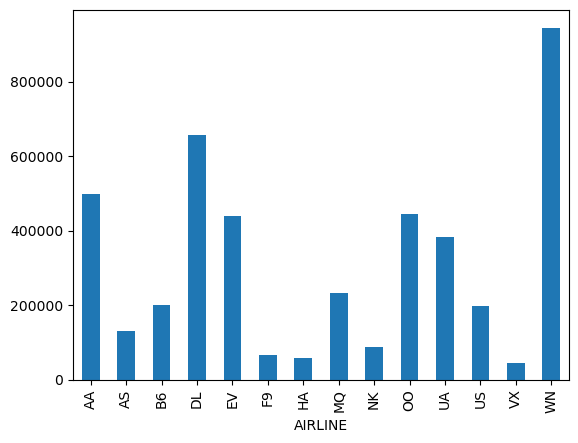

In [419]:
a = flights.groupby('AIRLINE')['DATE'].count()
a.plot(kind='bar')

Посмотрим, как распределяется время задержки по отношению к общему количеству рейсов для аэропортов. Здесь я хотел показать, что погода одинаково влияет на возможность вовремя вылететь.

In [420]:
a = flights.groupby('ORIGIN_AIRPORT')['WEATHER_DELAY'].sum().sort_values(ascending=False).reset_index()
a1 = flights.groupby('ORIGIN_AIRPORT')['DATE'].count().sort_values(ascending=False).reset_index()
a['WEATHER_DELAY'] = a['WEATHER_DELAY']/a1['DATE']

b = airports.merge(a, how='right', left_on='IATA_CODE', right_on='ORIGIN_AIRPORT')

In [541]:
fig = px.scatter_mapbox(b,
                        lon = b.LONGITUDE,
                        lat = b.LATITUDE,
                        zoom = 3,
                        color = b.WEATHER_DELAY,
                        size = b.WEATHER_DELAY,
                        width = 800,
                        height = 600,
)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

Добавляю для каждого дня количество вылетов из аэропорта

In [422]:
c_time = flights.groupby('DATE').count().reset_index()
c_time['C_TIME'] = c_time['MONTH']
c_time = c_time[['DATE', 'C_TIME']]
flights = flights.merge(c_time, how='left', left_on='DATE', right_on='DATE')

In [423]:
flights.head(2)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,DATE,PROBABILITY,C_TIME
0,2015,1,1,4,EV,5103,N846AS,ABE,DTW,600,...,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.4404,2015-01-01,1,13950
1,2015,1,1,4,EV,5579,N136EV,ABE,ATL,635,...,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.4404,2015-01-01,1,13950


In [424]:
flights.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'IATA_CODE', 'AIRPORT', 'CITY',
       'STATE', 'COUNTRY', 'LATITUDE', 'LONGITUDE', 'DATE', 'PROBABILITY',
       'C_TIME'],
      dtype='object')

In [ ]:
colormap = plt.cm.viridis
plt.figure(figsize=(30,30))
plt.title('Попарная корреляция', y=1.05, size=20)
sns.heatmap(flights.corr(), square=True, annot=True, cmap=colormap)
plt.show()

формирую датасет из колонок, таргет - верояность вылететь в срок

In [474]:
my_flight = flights[['DAY_OF_WEEK',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'DATE', 'PROBABILITY',
       'C_TIME', 'AIRLINE', 'FLIGHT_NUMBER', 'DISTANCE', ]]

In [475]:
my_flight['PROBABILITY'] = my_flight['PROBABILITY']*100

/var/folders/m9/x7jxk9jx2g9ch4ngnwz3n8wh0000gn/T/ipykernel_20130/2268286733.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
my_flight['ORIGIN_AIRPORT'].unique()

Выбираю аэропорт отправления

In [530]:
ATL = my_flight.query("ORIGIN_AIRPORT == 'ATL'")

In [ ]:
ATL['DESTINATION_AIRPORT'].unique()

Выбираю аэропорт прилета

In [570]:
ATL_IAD = ATL.query("DESTINATION_AIRPORT =='ORD'")

In [571]:
ATL_IAD.shape[0]

5301

Готовлю данные - выбираю в качестве индекса колонку с датой. Генерирую дополнительные фичи. Попробовал сэмитировать изменение количества рейсов по дням

In [572]:
ATL_IAD.set_index('DATE', inplace=True)
ATL_IAD.drop(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], axis=1, inplace=True)
ATL_IAD = ATL_IAD.groupby('DATE').mean()
for lag in range(1, 30 + 1):
    ATL_IAD['lag_{}'.format(lag)] = (ATL_IAD['C_TIME'].shift(lag) - ATL_IAD['C_TIME'].shift(lag+1)).rolling(7).mean()
ATL_IAD['y_mean'] = ATL_IAD['C_TIME'].shift().rolling(7).mean().copy()

/var/folders/m9/x7jxk9jx2g9ch4ngnwz3n8wh0000gn/T/ipykernel_20130/2305455250.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Присваиваю колонке со строковым типом данных цифры

In [ ]:
le = LabelEncoder()
ATL_IAD.AIRLINE = le.fit_transform(ATL_IAD['AIRLINE'])
#ATL_IAD.DESTINATION_AIRPORT = le.fit_transform(ATL_IAD['DESTINATION_AIRPORT'])



Удаляю пропуски

In [573]:
ATL_IAD.dropna(inplace=True)

Формирую тестовую и тренировочную выборки

In [574]:
X_train,X_test, y_train, y_test = train_test_split(ATL_IAD.drop('PROBABILITY',axis=1),
                                                  ATL_IAD.PROBABILITY,
                                                  shuffle = False,
                                                  test_size = 0.2)

In [575]:
lr = LinearRegression()
#sc = StandardScaler()
lr.fit(X_train, y_train)
print('Ошибка на обучающей выборке', (mean_squared_error(y_train, lr.predict(X_train)))**0.5)
pred = lr.predict(X_test)
print('Ошибка на тесте', (mean_squared_error(y_test, pred))**0.5)

Ошибка на обучающей выборке 14.302061503858663
Ошибка на тесте 18.49202312302031


In [576]:
gb = GradientBoostingRegressor()
#sc = StandardScaler()
gb.fit(X_train, y_train)
print('Ошибка на обучающей выборке', (mean_squared_error(y_train, gb.predict(X_train)))**0.5)
pred = gb.predict(X_test)
print('Ошибка на тесте', (mean_squared_error(y_test, pred))**0.5)

Ошибка на обучающей выборке 3.3844802378780936
Ошибка на тесте 17.74680099223185


In [577]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
print('Ошибка на обучающей выборке', (mean_squared_error(y_train, dt.predict(X_train)))**0.5)
pred = dt.predict(X_test)
print('Ошибка на тесте', (mean_squared_error(y_test, pred))**0.5)

Ошибка на обучающей выборке 0.0
Ошибка на тесте 25.976715777713213


In [578]:
rf = RandomForestRegressor(n_estimators=10, random_state=0)
rf.fit(X_train, y_train)
print('Ошибка на обучающей выборке', (mean_squared_error(y_train, rf.predict(X_train)))**0.5)
pred = gb.predict(X_test)
print('Ошибка на тесте', (mean_squared_error(y_test, pred))**0.5)

Ошибка на обучающей выборке 6.699579048435085
Ошибка на тесте 17.74680099223185


Показатели плохие. Изначально не усреднял данные, RMSE была более 30. Подскажите, на что обратить внимание. Возможно я не верно понял задание. Спасибо